# Analyse de survie en pratique

In [1]:
from jyquickhelper import add_notebook_menu

add_notebook_menu()

## Quelques données

On récupère les données disponibles sur *open.data.gouv.fr* [Données hospitalières relatives à l'épidémie de COVID-19](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/). Ces données ne permettent pas de construire la courbe de [Kaplan-Meier](https://fr.wikipedia.org/wiki/Estimateur_de_Kaplan-Meier). On sait combien de personnes rentrent et sortent chaque jour mais on ne sait pas quand une personne qui sort un 1er avril est entrée.

In [2]:
import numpy.random as rnd

import pandas

df = pandas.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/e3d83ab3-dc52-4c99-abaf-8a38050cc68c",
    sep=";",
)
gr = df[["jour", "rad", "dc"]].groupby(["jour"]).sum()
diff = gr.diff().reset_index(drop=False)
diff.head()

,jour,rad,dc
0,2020-03-18,NaN,NaN
1,2020-03-19,695.0,207.0
2,2020-03-20,806.0,248.0
3,2020-03-21,452.0,151.0
4,2020-03-22,608.0,210.0


In [3]:
def donnees_artificielles(hosp, mu=14, nu=21):
    dt = pandas.to_datetime(hosp["jour"])
    res = []
    for i in range(hosp.shape[0]):
        date = dt[i].dayofyear
        h = hosp.iloc[i, 1]
        delay = rnd.exponential(mu, int(h))
        for j in range(delay.shape[0]):
            res.append([date - int(delay[j]), date, 1])
        h = hosp.iloc[i, 2]
        delay = rnd.exponential(nu, int(h))
        for j in range(delay.shape[0]):
            res.append([date - int(delay[j]), date, 0])
    return pandas.DataFrame(res, columns=["entree", "sortie", "issue"])


data = donnees_artificielles(diff[1:].reset_index(drop=True)).sort_values("entree")
data.head()

,entree,sortie,issue
518488,-200,19,0
541408,-192,27,0
476735,-187,2,0
587013,-185,42,0
476057,-180,1,0


Chaque ligne est une personne, `entree` est le jour d'entrée à l'hôpital, `sortie` celui de la sortie, `issue`, 0 pour décès, 1 pour en vie.

In [4]:
data.describe()

,entree,sortie,issue
count,624130.000000,624130.000000,624130.000000
mean,169.704510,184.532815,0.806729
std,125.420957,124.343186,0.394864
min,-200.000000,1.000000,0.000000
25%,53.000000,84.000000,1.000000
50%,133.000000,144.000000,1.000000
75%,301.000000,315.000000,1.000000
max,366.000000,366.000000,1.000000


Il y a environ 80% de survie dans ces données.

In [5]:
import numpy

duree = data.sortie - data.entree
deces = (data.issue == 0).astype(numpy.int32)

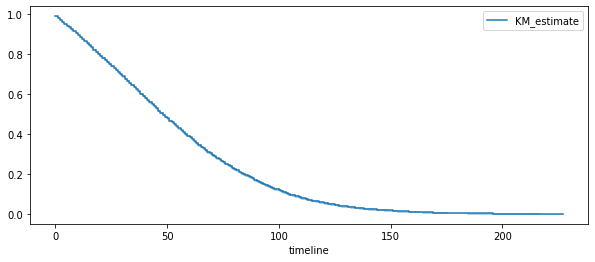

In [6]:
import numpy
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
kmf = KaplanMeierFitter()
kmf.fit(duree, deces)
kmf.plot(ax=ax)
ax.legend();

## Régression de Cox

On reprend les données artificiellement générées et on ajoute une variable identique à la durée plus un bruit mais quasi nul 

In [7]:
import pandas

data_simple = pandas.DataFrame(
    {
        "duree": duree,
        "deces": deces,
        "X1": duree * 0.57 * deces + numpy.random.randn(duree.shape[0]),
        "X2": duree * (-0.57) * deces + numpy.random.randn(duree.shape[0]),
    }
)
data_simple.head()

,duree,deces,X1,X2
518488,219,1,125.653230,-125.666662
541408,219,1,126.006024,-125.327549
476735,189,1,107.920779,-108.358230
587013,227,1,129.788930,-130.045019
476057,181,1,103.642440,-103.793008


In [8]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_simple, test_size=0.8)

In [9]:
from lifelines.fitters.coxph_fitter import CoxPHFitter

cox = CoxPHFitter()
cox.fit(
    data_train[["duree", "deces", "X1"]],
    duration_col="duree",
    event_col="deces",
    show_progress=True,
)


Iteration 1: norm_delta = 0.13943, step_size = 0.9000, log_lik = -250658.36250, newton_decrement = 889.93933, seconds_since_start = 0.0

Iteration 2: norm_delta = 0.00660, step_size = 0.9000, log_lik = -249862.37270, newton_decrement = 2.81312, seconds_since_start = 0.0

Iteration 3: norm_delta = 0.00073, step_size = 0.9000, log_lik = -249859.57376, newton_decrement = 0.03357, seconds_since_start = 0.1

Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -249859.54017, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 124826 total observations, 100754 right-censored observations>

In [10]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 124826 total observations, 100754 right-censored observations>
             duration col = 'duree'
                event col = 'deces'
      baseline estimation = breslow
   number of observations = 124826
number of events observed = 24072
   partial log-likelihood = -249859.54
         time fit was run = 2021-02-24 23:48:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X1          0.02       1.02       0.00             0.02             0.02                 1.02                 1.02

              z      p   -log2(p)
covariate                        
X1        42.23 <0.005        inf
---
Concordance = 0.69
Partial AIC = 499721.08
log-likelihood ratio test = 1597.64 on 1 df
-log2(p) of ll-ratio test = inf

In [11]:
cox2 = CoxPHFitter()
cox2.fit(
    data_train[["duree", "deces", "X2"]],
    duration_col="duree",
    event_col="deces",
    show_progress=True,
)
cox2.print_summary()


Iteration 1: norm_delta = 0.13946, step_size = 0.9000, log_lik = -250658.36250, newton_decrement = 888.92089, seconds_since_start = 0.0

Iteration 2: norm_delta = 0.00667, step_size = 0.9000, log_lik = -249863.61089, newton_decrement = 2.86434, seconds_since_start = 0.0

Iteration 3: norm_delta = 0.00074, step_size = 0.9000, log_lik = -249860.76079, newton_decrement = 0.03426, seconds_since_start = 0.1

Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -249860.72650, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 124826 total observations, 100754 right-censored observations>
             duration col = 'duree'
                event col = 'deces'
      baseline estimation = breslow
   number of observations = 124826
number of events observed = 24072
   partial log-likelihood = -249860.73
         time fit was run = 2021-02-24 23:48:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X2         -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98

               z      p   -log2(p)
covariate                         
X2        -42.21 <0.005        inf
---
Concordance = 0.69
Partial AIC = 499723.45
log-likelihood ratio test = 1595.27 on 1 df
-log2(p) of ll-ratio test = inf

In [12]:
cox.predict_cumulative_hazard(data_test[:5])

,621725,110352,139986,72623,248121
0.0,0.008806,0.008673,0.008543,0.008717,0.008661
1.0,0.018218,0.017942,0.017673,0.018035,0.017918
2.0,0.026735,0.026330,0.025936,0.026466,0.026295
3.0,0.036002,0.035457,0.034926,0.035640,0.035409
4.0,0.045543,0.044854,0.044182,0.045085,0.044793
...,...,...,...,...,...
184.0,2.055736,2.024623,1.994277,2.035070,2.021872
189.0,2.092002,2.060340,2.029459,2.070971,2.057541
197.0,2.138687,2.106318,2.074747,2.117186,2.103457
201.0,2.205513,2.172133,2.139576,2.183341,2.169182


In [13]:
cox.predict_survival_function(data_test[:5])

,621725,110352,139986,72623,248121
0.0,0.991233,0.991365,0.991494,0.991321,0.991377
1.0,0.981947,0.982218,0.982482,0.982127,0.982242
2.0,0.973619,0.974013,0.974398,0.973881,0.974048
3.0,0.964638,0.965164,0.965677,0.964988,0.965211
4.0,0.955478,0.956137,0.956780,0.955916,0.956196
...,...,...,...,...,...
184.0,0.127999,0.132044,0.136112,0.130671,0.132407
189.0,0.123440,0.127411,0.131407,0.126063,0.127768
197.0,0.117809,0.121685,0.125588,0.120370,0.122034
201.0,0.110194,0.113934,0.117705,0.112664,0.114271
